# **Time Series Forcasting**

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import numpy as np
import pandas as pd
from scipy import stats 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import ast
from scipy.interpolate import make_interp_spline
from sklearn import metrics
import seaborn as sns
from scipy.fft import fft,dct,ifft
import warnings
warnings.filterwarnings("ignore")

In [3]:
dataset = pd.read_csv('/content/drive/MyDrive/Deep_learning/airline-price-prediction.csv')
dataset.head()

,date,airline,ch_code,num_code,dep_time,time_taken,stop,arr_time,type,route,price
0,5/3/2022,Vistara,UK,812,9:45,10h 10m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,19:55,business,"{'source': 'Bangalore', 'destination': 'Hydera...","56,588"
1,18-03-2022,Vistara,UK,975,5:45,06h 30m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,12:15,business,"{'source': 'Delhi', 'destination': 'Hyderabad'}","59,649"
2,9/3/2022,GO FIRST,G8,7537,14:30,08h 10m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,22:40,economy,"{'source': 'Mumbai', 'destination': 'Hyderabad'}","3,916"
3,15-03-2022,GO FIRST,G8,287,10:40,09h 40m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:20,economy,"{'source': 'Mumbai', 'destination': 'Delhi'}","6,031"
4,22-03-2022,Vistara,UK,826,12:30,07h 25m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,19:55,economy,"{'source': 'Chennai', 'destination': 'Kolkata'}","7,081"


In [4]:
np.sum(dataset.duplicated())

0

Exploring the data types of the features

In [6]:
dataset.dtypes

date          object
airline       object
ch_code       object
num_code       int64
dep_time      object
time_taken    object
stop          object
arr_time      object
type          object
route         object
price         object
dtype: object

In [5]:
np.sum(dataset.isna())

date          0
airline       0
ch_code       0
num_code      0
dep_time      0
time_taken    0
stop          0
arr_time      0
type          0
route         0
price         0
dtype: int64

#These columns are one of 2 things :
1. Either a format fix of an original feature
2. A new feature I am going to extract from the data

In [8]:
dataset['formatted_date'] = 0
dataset['source'] = 0
dataset['destination'] = 0
dataset['flight_day'] = 0
dataset['flight_month'] = 0
dataset['num_of_stops'] = 0
dataset['formatted_price'] =0
dataset['num_of_hours_taken'] =0
dataset['week_day_of_flight'] = 0
dataset['distance_bet_2_countries'] = 0
dataset['one_stop_in'] = 'Not Found'

# There were 2 ways to explain to python that date feature was of type datetime, one way was to convert it using pandas to datetime but unfortunately the month and the day were swapped in the new format, so the other approach was to do it manually

In [9]:
def format_dates():
  observation = 0
  for date in dataset['date']:
      dataset['formatted_date'][observation] = date.replace('/','-')
      observation += 1

# Extracting the day of the month and the month, and choosing a datetime format where the month is explicitly mentioned and there is no way for error in swapping the day with the month

In [10]:
def extract_day_month():
  observation = 0
  for date in dataset['formatted_date']:
       format = date.split('-')
       dataset['flight_day'][observation] = int(format[0])
       dataset['flight_month'][observation] =int(format[1])
       if format[1]== '2' or format[1]== '02':
         dataset['formatted_date'][observation] = 'February ' + format[0] + ', '+ format[2]
       else :
         dataset['formatted_date'][observation] = 'March ' + format[0] + ', '+ format[2]
       observation+=1

# Pandas datetime has a lot of features that can be extracted easily from the date, like the day of the week which I believe is an important feature

In [11]:
def extract_weekday():
  observation =0
  dataset['formatted_date'] = pd.to_datetime(dataset['formatted_date'])
  for day in dataset['formatted_date']:
      dataset['week_day_of_flight'][observation]= day.day_name()
      observation +=1

In [12]:
format_dates()

In [13]:
extract_day_month()

In [14]:
extract_weekday()

In [15]:
dataset.head()

,date,airline,ch_code,num_code,dep_time,time_taken,stop,arr_time,type,route,...,source,destination,flight_day,flight_month,num_of_stops,formatted_price,num_of_hours_taken,week_day_of_flight,distance_bet_2_countries,one_stop_in
0,5/3/2022,Vistara,UK,812,9:45,10h 10m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,19:55,business,"{'source': 'Bangalore', 'destination': 'Hydera...",...,0,0,5,3,0,0,0,Saturday,0,Not Found
1,18-03-2022,Vistara,UK,975,5:45,06h 30m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,12:15,business,"{'source': 'Delhi', 'destination': 'Hyderabad'}",...,0,0,18,3,0,0,0,Friday,0,Not Found
2,9/3/2022,GO FIRST,G8,7537,14:30,08h 10m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,22:40,economy,"{'source': 'Mumbai', 'destination': 'Hyderabad'}",...,0,0,9,3,0,0,0,Wednesday,0,Not Found
3,15-03-2022,GO FIRST,G8,287,10:40,09h 40m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:20,economy,"{'source': 'Mumbai', 'destination': 'Delhi'}",...,0,0,15,3,0,0,0,Tuesday,0,Not Found
4,22-03-2022,Vistara,UK,826,12:30,07h 25m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,19:55,economy,"{'source': 'Chennai', 'destination': 'Kolkata'}",...,0,0,22,3,0,0,0,Tuesday,0,Not Found


# Here I am using the abstract syntax tree library to change the strings in route feature to a dictionary so that accessing the source and destination would be easy

In [16]:
def split_route():
  observation = 0
  for route in dataset['route']:
      flight = ast.literal_eval(route)
      dataset['source'][observation] = flight['source']
      dataset['destination'][observation] = flight['destination']
      observation +=1

In [17]:
split_route()

In [ ]:
dataset.head()

,date,airline,ch_code,num_code,dep_time,time_taken,stop,arr_time,type,route,...,source,destination,flight_day,flight_month,num_of_stops,formatted_price,num_of_hours_taken,week_day_of_flight,distance_bet_2_contries,one_stop_in
0,5/3/2022,Vistara,UK,812,9:45,10h 10m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,19:55,business,"{'source': 'Bangalore', 'destination': 'Hydera...",...,Bangalore,Hyderabad,5,3,0,0,0,Saturday,0,Not Found
1,18-03-2022,Vistara,UK,975,5:45,06h 30m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,12:15,business,"{'source': 'Delhi', 'destination': 'Hyderabad'}",...,Delhi,Hyderabad,18,3,0,0,0,Friday,0,Not Found
2,9/3/2022,GO FIRST,G8,7537,14:30,08h 10m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,22:40,economy,"{'source': 'Mumbai', 'destination': 'Hyderabad'}",...,Mumbai,Hyderabad,9,3,0,0,0,Wednesday,0,Not Found
3,15-03-2022,GO FIRST,G8,287,10:40,09h 40m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:20,economy,"{'source': 'Mumbai', 'destination': 'Delhi'}",...,Mumbai,Delhi,15,3,0,0,0,Tuesday,0,Not Found
4,22-03-2022,Vistara,UK,826,12:30,07h 25m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,19:55,economy,"{'source': 'Chennai', 'destination': 'Kolkata'}",...,Chennai,Kolkata,22,3,0,0,0,Tuesday,0,Not Found


In [18]:
def split_num_of_stops():
  observation= 0
  for stop in dataset['stop']:
    if stop[:8] == 'non-stop':
      dataset['num_of_stops'][observation] = 0
    elif stop[:6] == '1-stop':
      dataset['num_of_stops'][observation] = 1
    else:
      dataset['num_of_stops'][observation] = 2
    observation+=1

In [19]:
split_num_of_stops()

In [20]:
def find_where_is_the_stop():
  observation = 0
  for stop in dataset['stop']:
     if stop[:6] == '1-stop':
        splitted = stop.split(' ')
        if len(splitted)>1:
           fine_splitting = splitted[1].split('\n')
           dataset['one_stop_in'][observation] = fine_splitting[0]
     observation+=1


In [21]:
find_where_is_the_stop()

# Most of the observations either the stop is not mentioned, or there wasn't a stop, the highest frequency is the 'Not Found', so it is safe to put all other stops in a class which represents that the stop is 'Found'

In [22]:
dataset.one_stop_in.value_counts()

Not Found         234370
IXU                 1487
IDR                 1099
Patna                559
Indore               299
PAT                  273
MYQ                  267
Bhubaneswar          248
KLH                  231
JGB                  149
JRG                  135
STV                  129
Delhi                123
BBI                  119
Hyderabad            107
IXE                   91
Ranchi                86
Raipur                78
Chennai               64
Guwahati              46
Mangalore             35
Mysore                33
Mumbai                27
VTZ                   22
Nagpur                21
Kolkata               18
NDC                   17
RPR                   16
Surat                 11
Lucknow               11
GOP                   10
Vishakhapatnam         7
NAG                    7
Kolhapur               4
GAU                    3
IXR                    3
GAY                    2
HYD                    1
Name: one_stop_in, dtype: int64

In [23]:
dataset['one_stop_in'] = [0 if stop == 'Not found' else 1 for stop in dataset ['one_stop_in']]

The price is an object due to the presence of a coma, and this needs to be fixed

In [24]:
def fix_price_format():
  observation = 0
  for price in dataset['price']:
    number = price.split(',')
    cost = number[0] + number[1]
    dataset['formatted_price'][observation] = int(cost)
    observation+=1

In [25]:
fix_price_format()

#There is a 100% dependancy between ch_code and the airline, as the ch_code is a code for the airline, so we dont need both as they represent the same thing

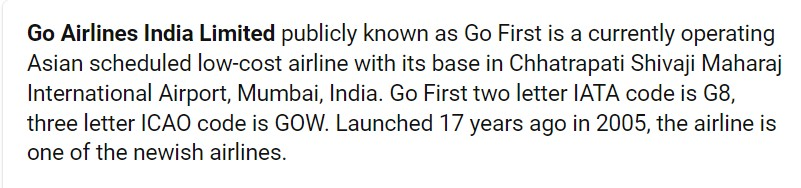

In [26]:
dataset.airline.value_counts()

Vistara      102177
Air India     64754
Indigo        34571
GO FIRST      18621
AirAsia       12785
SpiceJet       7216
StarAir          48
Trujet           36
Name: airline, dtype: int64

In [27]:
dataset.ch_code.value_counts()

UK    102177
AI     64754
6E     34571
G8     18621
I5     12785
SG      7216
S5        48
2T        36
Name: ch_code, dtype: int64

# The distance between the 2 countries might be and important feature
(yes I searched for the distance between all of them :) , also the distance is in kilometers)

In [28]:
def calculate_distance():
  distances = dict()
  distances['Mumbai','Kolkata'] = 2167
  distances['Mumbai','Hyderabad'] = 721
  distances['Mumbai','Chennai'] = 1344
  distances['Mumbai','Bangalore'] = 995
  distances['Mumbai','Delhi'] = 1439
  distances['Delhi','Bangalore'] = 2169
  distances['Delhi','Kolkata'] = 1554
  distances['Delhi','Hyderabad'] = 1579
  distances['Delhi','Chennai'] = 2202
  distances['Bangalore','Kolkata']= 1560
  distances['Bangalore','Hyderabad'] = 569
  distances['Bangalore','Chennai'] = 348
  distances['Kolkata','Hyderabad'] = 1489
  distances['Kolkata','Chennai'] = 1663
  distances['Hyderabad','Chennai'] = 628
  for observation in range(len(dataset['source'])):
     try :
       dist = distances[dataset['destination'][observation],dataset['source'][observation]]
     except :
       dist = distances[dataset['source'][observation],dataset['destination'][observation]]
     dataset['distance_bet_2_countries'][observation]= dist
  dataset['distance_bet_2_countries'] =  dataset['distance_bet_2_countries']/ dataset['distance_bet_2_countries'].max()

In [29]:
calculate_distance()

# The time taken is specified by the number of hours and the number of miutes, since we are using the hours only, to make use of the minutes, we choose a threshold of 40 minutes to add 1 to the hours 

In [30]:
def calculate_time_taken():
  observation = 0
  for time_taken in dataset['time_taken']:
     time = time_taken.split(' ')
     float_hour = time[0].split('.')
     if(len(float_hour)>1):
        time[0] = float_hour[0] + 'h'
        time[1]= float_hour[1][:-1] + time[1]
     if time[1][:-1] != '' : 
        if int(time[1][:-1]) >= 40 :
           dataset['num_of_hours_taken'][observation] = int(time[0][:-1]) + 1
        else :
           dataset['num_of_hours_taken'][observation] = int(time[0][:-1]) 
     else :
           dataset['num_of_hours_taken'][observation] = int(time[0][:-1])
     observation+=1

In [31]:
calculate_time_taken()

# We choose 1 to represent business class as it will always be more exprensive that the economy class, so the model could train a large weight for it only used in business

In [32]:
dataset['type'] = [1 if kind_of_trip == 'business' else 0 for kind_of_trip in dataset['type']]

#There are two types of a class imbalace
1. Label imbalance -> where one label is dominating 
2. Feature imbalance -> where a class in a specific feature is the one that appears the most

To avoid feature imbalance we can calculate the percentage of the classes in each feature and those features of low frequencies in the observations can all be put in an "Others" class

In [33]:
def get_feature_percentage():
   size = dataset.shape[0]
   ctr = 0
   for index in dataset.airline.value_counts().index:
      percentage = (int(dataset.airline.value_counts()[ctr])/size)*100
      print("Airline '{index}' represents '{percentage}' of the data".format(index = index,percentage =percentage))
      ctr += 1

In [34]:
get_feature_percentage()

Airline 'Vistara' represents '42.53688469992673' of the data
Airline 'Air India' represents '26.957470192499834' of the data
Airline 'Indigo' represents '14.392110171184974' of the data
Airline 'GO FIRST' represents '7.752031572637049' of the data
Airline 'AirAsia' represents '5.322470525544528' of the data
Airline 'SpiceJet' represents '3.004063145274096' of the data
Airline 'StarAir' represents '0.019982681675880902' of the data
Airline 'Trujet' represents '0.014987011256910678' of the data


#Airlines Vistara, Air India, and Indigo form 82% of the feature, so we can safely put all other airlines in the other class

In [35]:
def remove_low_frequency_airlines():
   high_frequency_airlines =['Vistara','Air India','Indigo']
   dataset ['airline'] = [airline if airline in high_frequency_airlines else 'Other_airline' for airline in dataset['airline']]
   

In [36]:
remove_low_frequency_airlines()

In [37]:
get_feature_percentage()

Airline 'Vistara' represents '42.53688469992673' of the data
Airline 'Air India' represents '26.957470192499834' of the data
Airline 'Other_airline' represents '16.11353493638846' of the data
Airline 'Indigo' represents '14.392110171184974' of the data


There is a 100% dependancy between arrival time, departure time and time taken, and this dependancy can be expressed by : time taken = arrival time - departure time.

Since using the hours themselves in arrival time and departure time will cause redundancy during training, we can extract the time of the day the flight departed and arrived as some times maybe cheaper or more expensive

In [38]:
def categorize_time(time):
  hours = time.split(':')
  hours[0] = int(hours[0])
  if hours[0] <6:
    return 'Early morning'
  elif 6<= hours[0] < 12 :
    return 'Morning'
  elif 12<= hours[0] < 18:
    return 'Afternoon'
  else:
    return 'Evening'

In [39]:
dataset['dep_time'] = dataset.dep_time.apply(lambda time: categorize_time(time))

In [40]:
dataset['arr_time'] = dataset.arr_time.apply(lambda time: categorize_time(time))

In [42]:
dataset.drop(columns=['date','ch_code','time_taken','stop','route','price','formatted_date','num_code'],axis = 1,inplace=True)

In [43]:
dataset.head()

,airline,dep_time,arr_time,type,source,destination,flight_day,flight_month,num_of_stops,formatted_price,num_of_hours_taken,week_day_of_flight,distance_bet_2_countries,one_stop_in
0,Vistara,Morning,Evening,1,Bangalore,Hyderabad,5,3,1,56588,10,Saturday,0.258401,1
1,Vistara,Early morning,Afternoon,1,Delhi,Hyderabad,18,3,1,59649,6,Friday,0.717075,1
2,Other_airline,Afternoon,Evening,0,Mumbai,Hyderabad,9,3,1,3916,8,Wednesday,0.327430,1
3,Other_airline,Morning,Evening,0,Mumbai,Delhi,15,3,1,6031,10,Tuesday,0.653497,1
4,Vistara,Afternoon,Evening,0,Chennai,Kolkata,22,3,1,7081,7,Tuesday,0.755223,1


# As the data is full of categories, there are many approaches to change categorical data to numerical ones, like the one hot encoding and target encoding, so I copied the data into another variable and both were done:
1.  Applied to one the target encoding, and I encoded the categories based on the average of their prices (as it is my label and what I want to reach)
2. Applied to the other the one hot encoding

In [54]:
dataset.groupby('dep_time')[['formatted_price']].mean()

,formatted_price
dep_time,
Afternoon,19369.093892
Early morning,11522.921204
Evening,22118.549422
Morning,21767.334193


In [55]:
target_encoded_dataset = dataset.copy()

In [56]:
def arranging_dep_time_by_price(time):
   if time =='Early morning':
     return 1
   elif time == 'Afternoon':
     return 2
   elif time == 'Morning':
     return 3
   else :
     return 4

In [57]:
target_encoded_dataset['dep_time'] = target_encoded_dataset.dep_time.apply(lambda time: arranging_dep_time_by_price(time))

Arrival time ordered by price is the same as departure time so we can use the same function

In [58]:
dataset.groupby('arr_time')[['formatted_price']].mean()

,formatted_price
arr_time,
Afternoon,19824.991704
Early morning,11210.585402
Evening,22271.023184
Morning,20995.469281


In [59]:
target_encoded_dataset['arr_time'] = target_encoded_dataset.arr_time.apply(lambda time: arranging_dep_time_by_price(time))

In [52]:
dataset.groupby('week_day_of_flight')[['formatted_price']].mean()

,formatted_price
week_day_of_flight,
Friday,20639.748577
Monday,20787.233494
Saturday,21361.187691
Sunday,21425.210986
Thursday,20506.297795
Tuesday,20462.125078
Wednesday,20611.392342


In [60]:
def arranging_day_by_price(day):
   if day =='Tuesday' :
     return 1
   elif day =='Thursday' :
     return 2
   elif day =='Wednesday' :
     return 3
   elif day =='Friday' :
     return 4
   elif day =='Monday' :
     return 5
   elif day =='Saturday' :
     return 6
   else :
     return 7

In [61]:
target_encoded_dataset['week_day_of_flight'] = target_encoded_dataset.week_day_of_flight.apply(lambda day: arranging_day_by_price(day))

In [53]:
dataset.groupby('airline')[['formatted_price']].mean()

,formatted_price
airline,
Air India,23441.239985
Indigo,5322.844060
Other_airline,5226.251331
Vistara,30315.066111


In [62]:
def arranging_airline_by_price(airline):
  if airline == 'Other_airline' :
    return 1
  elif airline == 'Indigo' :
    return 2
  elif airline == 'Air India' :
    return 3
  else :
    return 4

In [63]:
target_encoded_dataset['airline'] = target_encoded_dataset.airline.apply(lambda airline: arranging_airline_by_price(airline))

In [69]:
dataset.groupby('source')[['formatted_price']].mean()

,formatted_price
source,
Bangalore,21499.373150
Chennai,21914.811625
Delhi,18870.098571
Hyderabad,20012.072367
Kolkata,21660.119667
Mumbai,21417.389238


In [70]:
def arranging_source_by_price(source):
  if source == 'Delhi' :
    return 1
  elif source == 'Hyderabad' :
    return 2
  elif source == 'Mumbai' :
    return 3
  elif source == 'Bangalore' :
    return 4
  elif source == 'Kolkata' :
    return 5
  else :
    return 6

In [71]:
target_encoded_dataset['source'] = target_encoded_dataset.source.apply(lambda source: arranging_airline_by_price(source))

In [72]:
dataset.groupby('source')[['formatted_price']].mean()

,formatted_price
source,
Bangalore,21499.373150
Chennai,21914.811625
Delhi,18870.098571
Hyderabad,20012.072367
Kolkata,21660.119667
Mumbai,21417.389238


In [73]:
target_encoded_dataset['destination'] = target_encoded_dataset.destination.apply(lambda destination: arranging_airline_by_price(destination))

In [74]:
target_encoded_dataset.head()

,airline,dep_time,arr_time,type,source,destination,flight_day,flight_month,num_of_stops,formatted_price,num_of_hours_taken,week_day_of_flight,distance_bet_2_countries,one_stop_in
0,4,3,4,1,4,4,5,3,1,56588,10,6,0.258401,1
1,4,1,2,1,4,4,18,3,1,59649,6,4,0.717075,1
2,1,2,4,0,4,4,9,3,1,3916,8,3,0.327430,1
3,1,3,4,0,4,4,15,3,1,6031,10,1,0.653497,1
4,4,2,4,0,4,4,22,3,1,7081,7,1,0.755223,1


In [79]:
target_encoded_dataset.drop(columns=['one_stop_in'],axis=1,inplace=True)

In [76]:
dataset = pd.get_dummies(dataset,columns=['airline','source','destination','week_day_of_flight','dep_time','arr_time'])

#Since this is a time series data, data must be sorted according to the date, from older to newer

In [82]:
dataset.sort_values(by = ['flight_month','flight_day',],inplace =True,kind = 'quicksort',ascending = True)

In [77]:
target_encoded_dataset.sort_values(by = ['flight_month','flight_day',],inplace =True,kind = 'quicksort',ascending = True)

In [81]:
target_encoded_dataset.to_csv("target_encoded_dataset.csv",index=False)

#Here we are exploring the shape of the data based on the month, this will be used when transforming the data into the frequency domain

In [ ]:
def draw_periodic_signal(dataFrame,condition,grouping_column,condition_column,label):
    df = dataFrame[dataFrame[condition_column]==condition]
    df = df.groupby(grouping_column)[[label]].mean()
    x_values = np.array(df.index)
    y_values = np.array(df[label])
    X_Y_Spline = make_interp_spline(np.array(x_values), y_values)
    X_ = np.linspace(x_values.min(), x_values.max(), 400)
    Y_ = X_Y_Spline(X_)
    plt.plot(X_,Y_)
    plt.show()

#We cannot form an exact opinion based on the observations of Febrauary, as our observations start from 11/2, and the data of the beginning of the month is lost

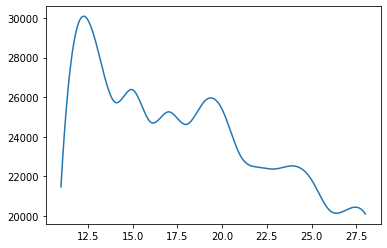

In [ ]:
draw_periodic_signal(dataset,2,'flight_day','flight_month','formatted_price')

#But we have all the data belonging to March

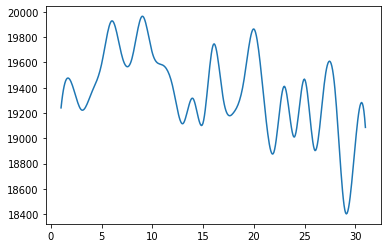

In [ ]:
draw_periodic_signal(dataset,3,'flight_day','flight_month','formatted_price')

# The data looks like a signal in the time domain, and since this is a time series data, we can transform the data to the frequency domain to get the most effective frequency componenets 

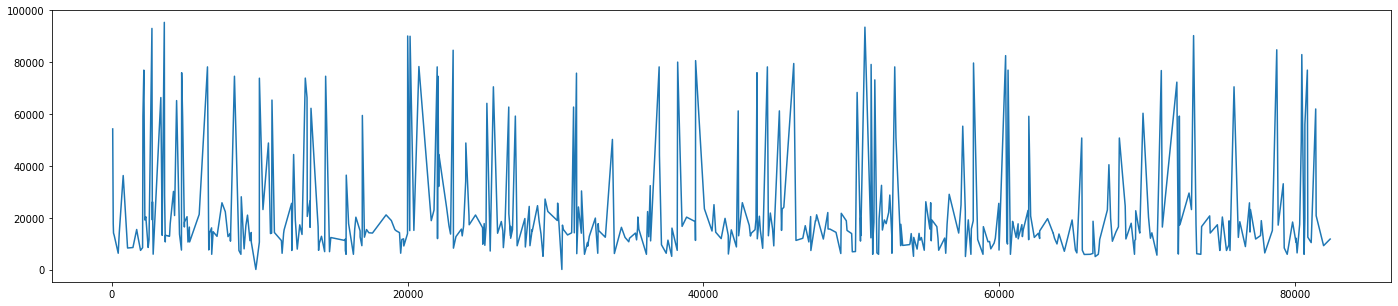

In [ ]:
dataset['formatted_price'][:500].plot(figsize=(24,5))

# Hypothesis testing using p value:
Our null hypothesis is that the model will make use of the feature otherwise the label is independant on that feature. 

So a p value < 0.05 proves the null hypothesis is true and a p value larger than it proves otherwise 

In [ ]:
for column in dataset.columns:
  if column != 'formatted_price':
    corr,pval = stats.pearsonr(dataset[column],dataset['formatted_price'])
    print("'{column}' has correlation of '{corr}' and pvalue of '{pval}'".format(column=column,corr=corr,pval=pval))

'num_code' has correlation of '-0.21328165646974237' and pvalue of '0.0'
'type' has correlation of '0.93750240226287' and pvalue of '0.0'
'flight_day' has correlation of '-0.0016491462215346506' and pvalue of '0.41894108875072933'
'flight_month' has correlation of '-0.09082852724064526' and pvalue of '0.0'
'num_of_stops' has correlation of '0.11833202764016981' and pvalue of '0.0'
'num_of_hours_taken' has correlation of '0.20467394733246583' and pvalue of '0.0'
'distance_bet_2_contries' has correlation of '-0.03928117102126485' and pvalue of '1.1765574710544293e-82'
'one_stop_in' has correlation of 'nan' and pvalue of 'nan'
'airline_Air India' has correlation of '0.07025874142095423' and pvalue of '1.777139640956704e-260'
'airline_Indigo' has correlation of '-0.28065623256420796' and pvalue of '0.0'
'airline_Other_airline' has correlation of '-0.30186788825425603' and pvalue of '0.0'
'airline_Vistara' has correlation of '0.3606804604143523' and pvalue of '0.0'
'source_Bangalore' has co

In [ ]:
for column in dataset.columns:
  if column != 'formatted_price':
    corr,pval = stats.pearsonr(dataset[column],dataset['formatted_price'])
    if pval > 0.05:
      dataset.drop(columns=column,axis=1,inplace=True)

In [ ]:
dataset.to_csv("processed_dataset.csv",index=False)